# 8. Predictions

## TOC

- [Graphing functions](#graphing-function)
- Prediction Algorithms
  - [Logistic Regression](#logistic-regression)
  - [Support Vector Machine](#support-vector-machine-svm)
  - [Decision Trees](#decision-trees)
  - [K-Nearest Neighbor](#k-nearest-neighbor-knn)


In [49]:
import pandas as pd
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier

import helpers as hlp

## Setup


In [50]:
INPUT_FILE = hlp.DATA_DIR / Path("04_eda_data.csv")
INPUT_FILE_PREDICTIONS = hlp.DATA_DIR / Path("06_prediction_data.csv")


## Graphing function


In [51]:
def plot_confusion_matrix(y, y_predict):
    """this function plots the confusion matrix"""
    from sklearn.metrics import confusion_matrix

    cm = confusion_matrix(y, y_predict)
    fig, ax = plt.subplots(figsize=(6, 2))
    sns.heatmap(cm, annot=True, ax=ax)  # annot=True to annotate cells
    ax.set_xlabel("Predicted labels")
    ax.set_ylabel("True labels")
    ax.set_title("Confusion Matrix")
    ax.xaxis.set_ticklabels(["did not land", "land"])
    ax.yaxis.set_ticklabels(["did not land", "landed"])
    plt.show()

## Load data


In [52]:
df = pd.read_csv(INPUT_FILE)
df.head()

,flight_number,date,booster_version,payload_mass,orbit,launch_site,outcome,flights,grid_fins,reused,legs,landing_pad,block,reused_count,serial,longitude,latitude,class
0,6,2010-06-04,Falcon 9,6123.547647,LEO,CCSFS SLC 40,None None,1,False,False,False,NaN,1.0,0,B0003,-80.577366,28.561857,0
1,8,2012-05-22,Falcon 9,525.000000,LEO,CCSFS SLC 40,None None,1,False,False,False,NaN,1.0,0,B0005,-80.577366,28.561857,0
2,10,2013-03-01,Falcon 9,677.000000,ISS,CCSFS SLC 40,None None,1,False,False,False,NaN,1.0,0,B0007,-80.577366,28.561857,0
3,11,2013-09-29,Falcon 9,500.000000,PO,VAFB SLC 4E,False Ocean,1,False,False,False,NaN,1.0,0,B1003,-120.610829,34.632093,0
4,12,2013-12-03,Falcon 9,3170.000000,GTO,CCSFS SLC 40,None None,1,False,False,False,NaN,1.0,0,B1004,-80.577366,28.561857,0


In [53]:
pred_df = pd.read_csv(INPUT_FILE_PREDICTIONS)
pred_df.head()

,flight_number,payload_mass,flights,grid_fins,reused,legs,block,reused_count,orbit_ES-L1,orbit_GEO,...,serial_B1048,serial_B1049,serial_B1050,serial_B1051,serial_B1054,serial_B1056,serial_B1058,serial_B1059,serial_B1060,serial_B1062
0,6.0,6123.547647,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,8.0,525.000000,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,10.0,677.000000,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,11.0,500.000000,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,12.0,3170.000000,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [54]:
pred_df.columns

Index(['flight_number', 'payload_mass', 'flights', 'grid_fins', 'reused',
       'legs', 'block', 'reused_count', 'orbit_ES-L1', 'orbit_GEO',
       'orbit_GTO', 'orbit_HEO', 'orbit_ISS', 'orbit_LEO', 'orbit_MEO',
       'orbit_PO', 'orbit_SO', 'orbit_SSO', 'orbit_VLEO',
       'launch_site_CCSFS SLC 40', 'launch_site_KSC LC 39A',
       'launch_site_VAFB SLC 4E', 'landing_pad_5e9e3032383ecb267a34e7c7',
       'landing_pad_5e9e3032383ecb554034e7c9',
       'landing_pad_5e9e3032383ecb6bb234e7ca',
       'landing_pad_5e9e3032383ecb761634e7cb',
       'landing_pad_5e9e3033383ecbb9e534e7cc', 'serial_B0003', 'serial_B0005',
       'serial_B0007', 'serial_B1003', 'serial_B1004', 'serial_B1005',
       'serial_B1006', 'serial_B1007', 'serial_B1008', 'serial_B1010',
       'serial_B1011', 'serial_B1012', 'serial_B1013', 'serial_B1015',
       'serial_B1016', 'serial_B1017', 'serial_B1018', 'serial_B1019',
       'serial_B1020', 'serial_B1021', 'serial_B1022', 'serial_B1023',
       'serial_B10

In [55]:
Y = pd.Series(df["class"])
Y.value_counts()

class
1    60
0    30
Name: count, dtype: int64

## Transform predictions


In [56]:
transform = preprocessing.StandardScaler()
X = transform.fit_transform(pred_df)
X.shape

(90, 80)

## Split into train and test sets


In [57]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=2)

print(f"Y test shape : {Y_test.shape}")

# check the shape of train X and Y
print(f"Y train shape: {X_train.shape}")
print(f"X train shape: {X_train.shape}")

Y test shape : (18,)
Y train shape: (72, 80)
X train shape: (72, 80)


## Logistic Regression


In [58]:
parameters = {
    "C": [0.01, 0.1, 1],
    "penalty": ["l2"],
    "solver": ["lbfgs"],
}  # l1 lasso l2 ridge

lr = LogisticRegression()

logreg_cv = GridSearchCV(estimator=lr, cv=10, param_grid=parameters)
logreg_cv.fit(X_train, Y_train)

,estimator,LogisticRegression()
,param_grid,"{'C': [0.01, 0.1, ...], 'penalty': ['l2'], 'solver': ['lbfgs']}"
,scoring,None
,n_jobs,None
,refit,True
,cv,10
,verbose,0
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,penalty,'l2'


### LR Accuracy & Score


In [59]:
logreg_cv_accuracy = logreg_cv.best_score_
print("tuned hyperparameters (best parameters) :", logreg_cv.best_params_)
print(f"accuracy : {logreg_cv_accuracy:.3f}")

logreg_cv_score = logreg_cv.score(X_test, Y_test)
print(f"LR algorithm score : {logreg_cv_score:.3f}")

tuned hyperparameters (best parameters) : {'C': 0.1, 'penalty': 'l2', 'solver': 'lbfgs'}
accuracy : 0.821
LR algorithm score : 0.833


### LR Confusion matrix


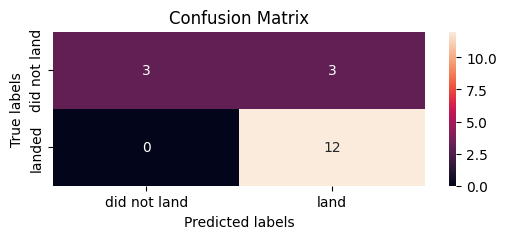

In [60]:
yhat = logreg_cv.predict(X_test)
plot_confusion_matrix(Y_test, yhat)

## Support Vector Machine (SVM)


In [61]:
parameters = {
    "kernel": ("linear", "rbf", "poly", "rbf", "sigmoid"),
    "C": np.logspace(-3, 3, 5),
    "gamma": np.logspace(-3, 3, 5),
}

svm = SVC()

svm_cv = GridSearchCV(estimator=svm, cv=10, param_grid=parameters)
svm_cv.fit(X_train, Y_train)

,estimator,SVC()
,param_grid,"{'C': array([1.0000...00000000e+03]), 'gamma': array([1.0000...00000000e+03]), 'kernel': ('linear', ...)}"
,scoring,None
,n_jobs,None
,refit,True
,cv,10
,verbose,0
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,C,np.float64(1.0)


### SVM Accuracy & Score


In [62]:
svm_cv_accuracy = svm_cv.best_score_
print("tuned hyperparameters (best parameters) :", svm_cv.best_params_)
print(f"accuracy : {svm_cv_accuracy:.3f}")

svm_cv_score = svm_cv.score(X_test, Y_test)
print(f"SVM algorithm score : {svm_cv_score:.3f}")

tuned hyperparameters (best parameters) : {'C': np.float64(1.0), 'gamma': np.float64(0.03162277660168379), 'kernel': 'sigmoid'}
accuracy : 0.848
SVM algorithm score : 0.833


### SVM Confusion matrix


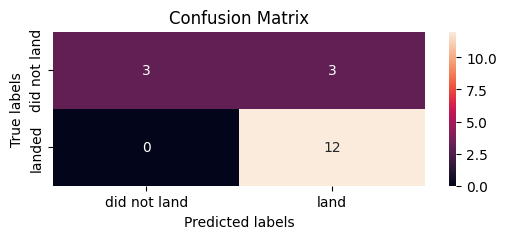

In [63]:
yhat = svm_cv.predict(X_test)
plot_confusion_matrix(Y_test, yhat)

## Decision Tree


In [64]:
parameters = {
    "criterion": ["gini", "entropy"],
    "splitter": ["best", "random"],
    "max_depth": [2 * n for n in range(1, 10)],
    "max_features": ["auto", "sqrt"],
    "min_samples_leaf": [1, 2, 4],
    "min_samples_split": [2, 5, 10],
}

tree = DecisionTreeClassifier()
tree_cv = GridSearchCV(estimator=tree, cv=10, param_grid=parameters)
tree_cv.fit(X_train, Y_train)

d:\CODE\COURSES\ibm-data-science-cert-capstone\.venv\Lib\site-packages\sklearn\model_selection\_validation.py:516: FitFailedWarning: 
3240 fits failed out of a total of 6480.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
3240 fits failed with the following error:
Traceback (most recent call last):
  File "d:\CODE\COURSES\ibm-data-science-cert-capstone\.venv\Lib\site-packages\sklearn\model_selection\_validation.py", line 859, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
    ~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "d:\CODE\COURSES\ibm-data-science-cert-capstone\.venv\Lib\site-packages\sklearn\base.py", line 1358, in wrapper
    estimator._validate_params()
    ~~~~~~~~~~~~~~~~~~~~~~~~~~^^
  File "d:\CO

,estimator,DecisionTreeClassifier()
,param_grid,"{'criterion': ['gini', 'entropy'], 'max_depth': [2, 4, ...], 'max_features': ['auto', 'sqrt'], 'min_samples_leaf': [1, 2, ...], ...}"
,scoring,None
,n_jobs,None
,refit,True
,cv,10
,verbose,0
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,criterion,'entropy'


### Decision Trees Accuracy & Score


In [65]:
tree_cv_accuracy = tree_cv.best_score_
print("tuned hyperparameters (best parameters) :", tree_cv.best_params_)
# this should be  ~83% accuracy according to grader
print(f"accuracy : {tree_cv_accuracy:.3f}")

tree_cv_score = tree_cv.score(X_test, Y_test)
print(f"DT algorithm score : {tree_cv_score:.3f}")

tuned hyperparameters (best parameters) : {'criterion': 'entropy', 'max_depth': 12, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 10, 'splitter': 'best'}
accuracy : 0.889
DT algorithm score : 0.944


### Decision Trees Confusion Matrix


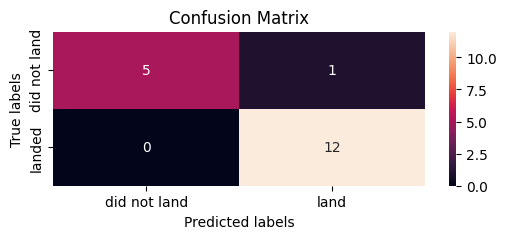

In [66]:
yhat = tree_cv.predict(X_test)
plot_confusion_matrix(Y_test, yhat)

## K-Nearest Neighbor (KNN)


In [67]:
parameters = {
    "n_neighbors": [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
    "algorithm": ["auto", "ball_tree", "kd_tree", "brute"],
    "p": [1, 2],
}

KNN = KNeighborsClassifier()

knn_cv = GridSearchCV(estimator=KNN, cv=10, param_grid=parameters)
knn_cv.fit(X_train, Y_train)

,estimator,KNeighborsClassifier()
,param_grid,"{'algorithm': ['auto', 'ball_tree', ...], 'n_neighbors': [1, 2, ...], 'p': [1, 2]}"
,scoring,None
,n_jobs,None
,refit,True
,cv,10
,verbose,0
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,n_neighbors,3


### KNN Accuracy & Score


In [68]:
knn_cv_accuracy = knn_cv.best_score_
print("tuned hyperparameters (best parameters) :", knn_cv.best_params_)
# this should be  ~83% accuracy according to grader
print(f"accuracy : {knn_cv_accuracy:.3f}")

knn_cv_score = tree_cv.score(X_test, Y_test)
print(f"KNN algorithm score : {knn_cv_score:.3f}")

tuned hyperparameters (best parameters) : {'algorithm': 'auto', 'n_neighbors': 3, 'p': 1}
accuracy : 0.834
KNN algorithm score : 0.944


### KNN Confusion Matrix


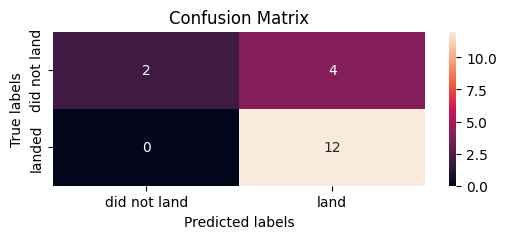

In [69]:
yhat = knn_cv.predict(X_test)
plot_confusion_matrix(Y_test, yhat)

## Find the algorithm that performs best

Our goal will be to find the algorithm with the highest score and the highest accuracy rate.

In this instance, SVM seems to be the one with the best results.


In [70]:
print(f"{' ' * 25} Score | Accuracy")
print(f"Logistic Regression     : {logreg_cv_score:>.4f} | {logreg_cv_accuracy:>.4f} ")
print(f"Support Vector Machine  : {svm_cv_score:>.4f} | {svm_cv_accuracy:>.4f} ")
print(f"Decision Tree           : {tree_cv_score:>.4f} | {tree_cv_accuracy:>.4f} ")
print(f"K-Nearest Neighbors     : {knn_cv_score:>.4f} | {knn_cv_accuracy:>.4f} ")

                          Score | Accuracy
Logistic Regression     : 0.8333 | 0.8214 
Support Vector Machine  : 0.8333 | 0.8482 
Decision Tree           : 0.9444 | 0.8893 
K-Nearest Neighbors     : 0.9444 | 0.8339 
